# [PLACEMENTIQ3] - Model selection

## 1 - Python stuff

In [1]:
import boto3
import pandas as pd
import numpy as np
import io
import os
import json
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

## 2 - Retrieve Dataset on AWS S3

### 2.1 AWS S3 config

In [2]:
with open("access_token.json", "rb") as file:
    token = json.load(file)

In [3]:
s3 = boto3.client(
    service_name = "s3",
    region_name = "eu-west-3",
    aws_access_key_id = token["aws_access_key_id"],
    aws_secret_access_key = token["aws_secret_access_key"],
)

In [4]:
bucket_name = "mlelements"

In [5]:
prefix = "datasets/"
filename_train = "cleaned_campus_selection_train.csv"

### 2.2 - Open CSV with pandas

In [6]:
result = s3.list_objects(Bucket=bucket_name)
for obj in result.get('Contents'):
    if (obj["Key"].startswith(prefix)) and (obj["Key"].endswith(filename_train)):
        data = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        contents = data['Body'].read().decode("utf-8")
        df_train = pd.read_csv(io.StringIO(contents), low_memory=False)

In [7]:
df_train.head()

sl_no gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0    202      M   54.2  Central   63.0   Others   Science      58.0   
1    131      M   62.0  Central   65.0   Others  Commerce      60.0   
2     80      F   69.0  Central   62.0  Central   Science      66.0   
3     15      M   62.0  Central   47.0  Central  Commerce      50.0   
4    211      M   80.6   Others   82.0   Others  Commerce      77.6   

    degree_t workex  etest_p specialisation  mba_p  status  
0  Comm&Mgmt     No     79.0         Mkt&HR  58.44       1  
1  Comm&Mgmt     No     84.0        Mkt&Fin  64.15       1  
2   Sci&Tech     No     75.0         Mkt&HR  67.99       1  
3  Comm&Mgmt     No     76.0         Mkt&HR  54.96       1  
4  Comm&Mgmt     No     91.0        Mkt&Fin  74.49       0

### 2.3 - Split data to X and y, data preprocessor

In [8]:
y = df_train["status"]
X = df_train.drop("status", axis=1)

In [9]:
categorical_data = selector(dtype_include=object)
numerical_data = selector(dtype_exclude=object)

In [10]:
n_categorical = categorical_data(X)
n_numerical = numerical_data(X)

In [11]:
print(f"Categorial : {len(n_categorical)}")
print(f"Numerical : {len(n_numerical)}")

Categorial : 7
Numerical : 6


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42
)

## 3 - Retrieve model on AWS S3

### 3.1 AWS config

In [13]:
prefix_model = "models/"
filename_model = "piq_model.pkl"

### 3.2 - Open pkl with joblib

In [14]:
result_model = s3.list_objects(Bucket=bucket_name)
for obj in result_model.get('Contents'):
    if (obj["Key"].startswith(prefix_model)) and (obj["Key"].endswith(filename_model)):
        model = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        model_content = model['Body'].read()
        model_pipeline = joblib.load(io.BytesIO(model_content))

### 3.3 - About the model

In [15]:
model_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['sl_no', 'ssc_p', 'hsc_p',
                                                   'degree_p', 'etest_p',
                                                   'mba_p']),
                                                 ('Categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'ssc_b', 'hsc_b',
                                                   'hsc_s', 'degree_t',
                                                   'workex',
                                                   'specialisation'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=3, max_leaf_nodes=10000))])

In [16]:
for parameter in model_pipeline.get_params():
    print(parameter)

memory
steps
verbose
columntransformer
randomforestclassifier
columntransformer__n_jobs
columntransformer__remainder
columntransformer__sparse_threshold
columntransformer__transformer_weights
columntransformer__transformers
columntransformer__verbose
columntransformer__verbose_feature_names_out
columntransformer__numerical
columntransformer__Categorical
columntransformer__numerical__copy
columntransformer__numerical__with_mean
columntransformer__numerical__with_std
columntransformer__Categorical__categories
columntransformer__Categorical__drop
columntransformer__Categorical__dtype
columntransformer__Categorical__feature_name_combiner
columntransformer__Categorical__handle_unknown
columntransformer__Categorical__max_categories
columntransformer__Categorical__min_frequency
columntransformer__Categorical__sparse
columntransformer__Categorical__sparse_output
randomforestclassifier__bootstrap
randomforestclassifier__ccp_alpha
randomforestclassifier__class_weight
randomforestclassifier__crit

## 4 - Hyperparameter tuning

### 4.1 - Applying GridSearchCV strategy

In [17]:
params = {
    "randomforestclassifier__max_features": [1, 2, 3, 5, None],
    "randomforestclassifier__max_leaf_nodes": [10, 100, 1_000, 10_000, None],
    "randomforestclassifier__min_samples_leaf": [1, 2, 5, 10, 20, 50, 100, 1_000],
}

In [18]:
search_cv = GridSearchCV(
    model_pipeline,
    param_grid=params,
    scoring="accuracy",
    n_jobs=-1,
    error_score='raise'
)

### 4.2 - GridSearchCV Results

In [19]:
search_cv.fit(X_train, y_train)

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         StandardScaler(),
                                                                         ['sl_no',
                                                                          'ssc_p',
                                                                          'hsc_p',
                                                                          'degree_p',
                                                                          'etest_p',
                                                                          'mba_p']),
                                                                        ('Categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['gender',
                                                                          'ssc_b',
                                                                          'hsc_b',
                                                                          'hsc_s',
                                                                          'degree_t',
                                                                          'workex',
                                                                          'specialisation'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(max_features=3,
                                                               max_leaf_nodes=10000))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_features': [1, 2, 3, 5,
                                                                  None],
                         'randomforestclassifier__max_leaf_nodes': [10, 100,
                                                                    1000, 10000,
                                                                    None],
                         'randomforestclassifier__min_samples_leaf': [1, 2, 5,
                                                                      10, 20,
                                                                      50, 100,
                                                                      1000]},
             scoring='accuracy')

In [20]:
cv_results = search_cv.cv_results_

In [21]:
pd.DataFrame(cv_results).sort_values(by="rank_test_score", ascending=True).head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
112       0.167319      0.005518         0.012547        0.000625   
194       0.199798      0.004527         0.019501        0.004696   
144       0.165167      0.007540         0.014905        0.001223   

    param_randomforestclassifier__max_features  \
112                                          3   
194                                       None   
144                                          5   

    param_randomforestclassifier__max_leaf_nodes  \
112                                         None   
194                                         None   
144                                        10000   

    param_randomforestclassifier__min_samples_leaf  \
112                                              1   
194                                              5   
144                                              1   

                                                params  split0_test_score  \
112  {'randomforestclassifier__max_features': 3, 'r...           0.882353   
194  {'randomforestclassifier__max_features': None,...           0.911765   
144  {'randomforestclassifier__max_features': 5, 'r...           0.852941   

     split1_test_score  split2_test_score  split3_test_score  \
112           0.941176           0.823529           0.848485   
194           0.941176           0.823529           0.848485   
144           0.911765           0.852941           0.848485   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
112           0.848485         0.868806        0.040735                1  
194           0.818182         0.868627        0.049211                2  
144           0.848485         0.862923        0.024502                3

### 4.3 - Best model metrics 

In [22]:
best_model = search_cv.best_estimator_
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['sl_no', 'ssc_p', 'hsc_p',
                                                   'degree_p', 'etest_p',
                                                   'mba_p']),
                                                 ('Categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'ssc_b', 'hsc_b',
                                                   'hsc_s', 'degree_t',
                                                   'workex',
                                                   'specialisation'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=3))])

In [23]:
result = best_model.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, result)
precision = precision_score(y_test, result)
recall = recall_score(y_test, result)

In [25]:
print(f"The accuracy score : {accuracy*100:.3f}%")
print(f"The precision score: {precision*100:.3f}%")
print(f"The recall score: {recall*100:.3f}%")

The accuracy score : 92.857%
The precision score: 100.000%
The recall score: 78.571%


In [26]:
confusion_matrix = confusion_matrix(y_test, result)

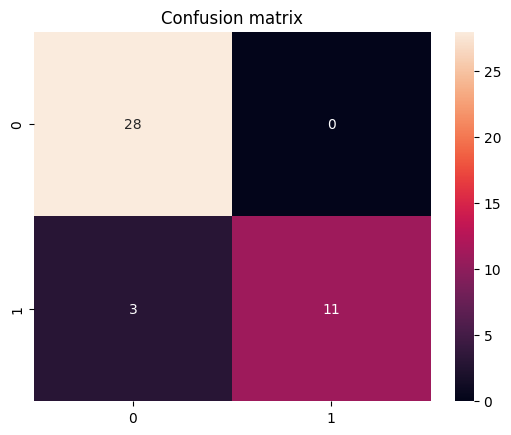

In [27]:
_ = sns.heatmap((confusion_matrix), annot=True).set(title="Confusion matrix")

In [28]:
label_map = {1: "Not Placed", 0: "Placed"}
y_train = y_train.map(label_map)

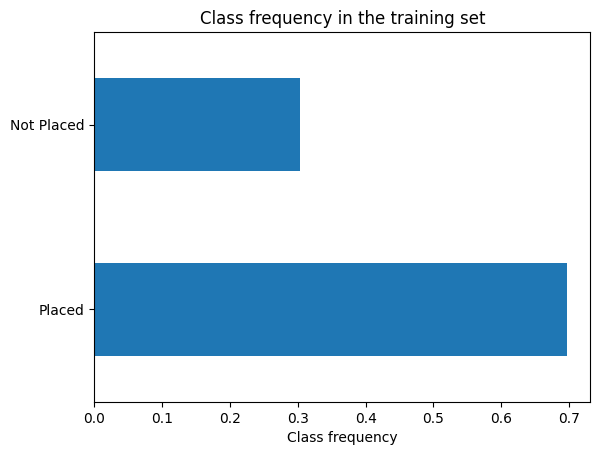

In [29]:
label_map = {"Placed": 0, "Not Placed": 1}
y_train_mapped = y_train.replace(label_map)
pd.Series(y_train).value_counts(normalize=True).plot.barh()
plt.xlabel("Class frequency")
plt.title("Class frequency in the training set")
plt.show()

## 5 - Export hyperparameters into S3

In [30]:
prefix = "models/"
tuned_model = "tuned_piq_model.pkl"

In [31]:
try:
    os.makedirs(prefix, exist_ok=True)
    joblib.dump(best_model, prefix+tuned_model)
    print(f"Successfully saved the tuned model as {tuned_model}")
except Exception as e:
    print(f"Error saving the model: {e}")

Successfully saved the tuned model as tuned_piq_model.pkl


In [32]:
s3.upload_file(prefix + tuned_model, bucket_name, prefix + tuned_model)

In [33]:
os.chdir(prefix)
os.remove(tuned_model)
print("models : ")
print("- - - " * 3)
if len(os.listdir()) > 1:
        for file in os.listdir():
            print(file)
else: 
    print("You'll retreive all models in AWS S3 !")
os.chdir("../")

models : 
- - - - - - - - - 
You'll retreive all models in AWS S3 !
